# Linear Algebraic Background Subtraction For Femtosecond Timing

## Intro

This notebook demonstrates how to perform a linear algebraic based background subtraction for isolating the edge in femto second x-ray/laser timing recovery. (SVD of signals themselves are shown too.)

Based on "Singular value decomposition as a tool for background corrections in time-resolved XFEL scattering data", Kristoffer Haldrup,Philosophical Transactions of the Royal Society B: Biological Sciences, page 20130336
June 4, 2014

## Loading Libraries

In [1]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from scipy.signal import savgol_filter
import os

## Initializing Data

### Loading Data

In [2]:
#load data
experiment_run_name = "xpptut15run420.h5"
my_file = experiment_run_name
my_hdf5_object = h5py.File(my_file,"r")

### Converting hdf5 to Python Dictionary

In [30]:
#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    my_dict[i] = array(my_hdf5_object[i])
pixel_to_femtosecond_list = []
width_list = []

## Visualizing Some Sample Data

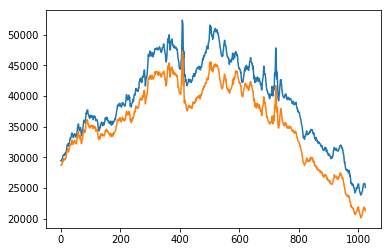

In [4]:
#plot some sample data
time_camera = 'timeToolOpal'
plot(my_dict[time_camera][0])
plot(my_dict[time_camera][3000])
show()

## Isolating and Displaying Some Sample Backgrounds

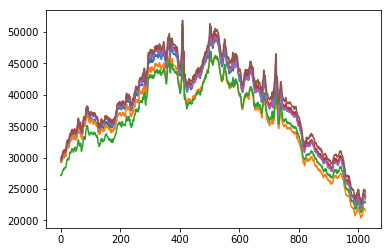

In [70]:
#identify background shots and plot some of them
my_dropped_shots = array(my_dict['evr/code_162']==1)              #this creates an array of booleans for dropped shots
atm_backgrounds = my_dict[time_camera][my_dropped_shots][::1]    #using the boolean array to select the dropped shots
plot(atm_backgrounds[30::400].transpose())
show()

# update gram schmidt ortho basis method 

In [113]:
#signal_of_interest mask
my_mask = my_dict[time_camera][0].astype(bool)
my_mask[0:500]=True
my_mask[500:900]=False
my_mask[900:]=True

In [114]:
time_constant        = 0.05
my_basis_size        = 6
my_ortho_basis = np.zeros([my_basis_size,atm_backgrounds.shape[1]])

In [115]:
tc = time_constant
simple_average = 0
second_basis   = np.random.rand(atm_backgrounds.shape[1])
third_basis   = np.random.rand(atm_backgrounds.shape[1])
for i in np.arange(len(atm_backgrounds)):
    residuals = 0
    simple_average = simple_average*(1-tc)+tc*atm_backgrounds[i]

    residuals     = atm_backgrounds[i]-np.dot(simple_average,atm_backgrounds[i])/np.dot(simple_average,simple_average)*simple_average

    second_basis  = second_basis*(1-tc)+ np.sign(np.dot(second_basis,residuals))*tc*residuals

    residuals     = residuals  -np.dot(second_basis,residuals)/np.dot(second_basis,second_basis)*second_basis

    third_basis  = third_basis*(1-tc)+ np.sign(np.dot(third_basis,residuals))*tc*residuals
        
        
    

In [128]:
#over writting v with update calculated
v = np.array([simple_average,second_basis,third_basis])

In [129]:
def mean_centered_norm(x):
    y = (x-np.mean(x))
    return y/np.dot(y,y)**0.5

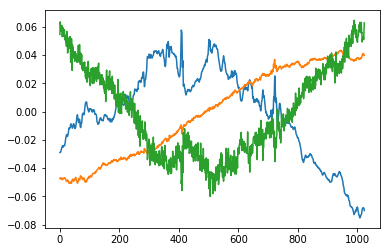

In [130]:
plt.plot(mean_centered_norm(simple_average))
plt.plot(mean_centered_norm(second_basis))
plt.plot(mean_centered_norm(third_basis))

##  Eigen-Backgrounds

### Calculating Eigen Backgrounds Using SVD

In [131]:
#singular value decomposition on background shots. variable v contains the eigen backgrounds
u,s,vd = svd(atm_backgrounds) 

### Showing Three Dominant Eigen Backgrounds

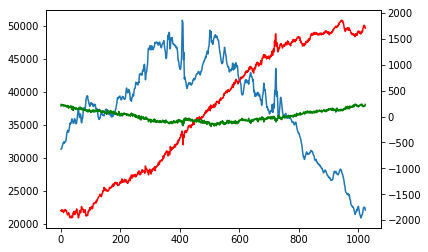

In [132]:
#showing some of the eigen backgrounds
plot(v[0])
twinx()
plot(v[1],'r-')
plot(v[2],'g-')
show()

### Remove the Eigen-Backgrounds from the Data With X-ray Timing Signal

In [133]:
my_mask = my_dict[time_camera][0].astype(bool)
my_mask[0:500]=True
my_mask[500:900]=False
my_mask[900:]=True

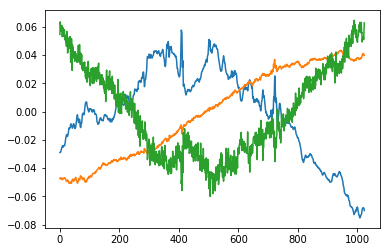

In [134]:
plt.plot(mean_centered_norm(simple_average))
plt.plot(mean_centered_norm(second_basis))
plt.plot(mean_centered_norm(third_basis))

In [135]:
#over writting v with update calculated
v = np.array([simple_average,second_basis,third_basis])

In [136]:
#subtracting the backgrounds from the data
svd_size = 3

#background_subtracted = my_dict[time_camera] - dot(dot(my_dict[time_camera],v[:svd_size].transpose()),v[:svd_size])
background_subtracted = my_dict[time_camera] - dot(dot(my_dict[time_camera][:,my_mask],pinv(v[:svd_size][:,my_mask])),v[:svd_size])

### Visualizing the Eigen Background Subtracted Timing X-ray Laser Intersection Edge

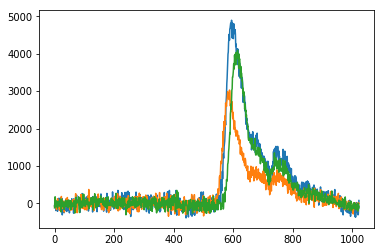

In [137]:
#plotting the background subtracted data
plot(background_subtracted[10])
plot(background_subtracted[2000])
plot(background_subtracted[4000])
show()

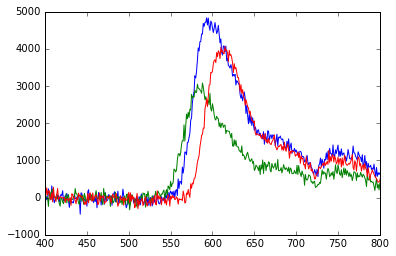

In [12]:
#zooming in
plot(background_subtracted[10])
plot(background_subtracted[2000])
plot(background_subtracted[4000])
xlim(400,800)
show()

### SVD of signal itself (compare to image above. it's less noisy)

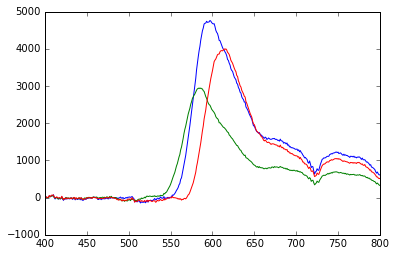

In [13]:
us,ss,vs = svd(background_subtracted[:4200])
us.shape,ss.shape,vs.shape
svd_size=10
ss_trunc = zeros([len(us),len(ss)])
ss_trunc[:svd_size,:svd_size] = diag(ss[:svd_size])
reconstructed_signal = dot(us,dot(ss_trunc,vs))
#zooming in
plot(reconstructed_signal[10])
plot(reconstructed_signal[2000])
plot(reconstructed_signal[4000])
xlim(400,800)
show()

## Calculating the Rising Edge Position

The rising edge position is calculated by convolving with a slope 25 pixels wide and finding the max of that slope by fitting a parabola in the vicinity of the local maximum.

In [14]:
recalculated_atm = []
recalculated_atm_cov = []
def peakFunction(x,a,x0,offset):
    return a*(x-x0)**2+offset
for i in arange(len(background_subtracted)):
    filtered_signal = savgol_filter(background_subtracted[i],25,2,1)      #calculates the rolling slope over 25 points
    win_c = argmax(abs(filtered_signal))
    initial_guess = [1,win_c,filtered_signal[win_c]]
    try:
        #fitting peak with a parabola
        popt,pcov = curve_fit(peakFunction,arange(win_c-4,win_c+5),abs(filtered_signal[win_c-4:win_c+5]), p0=initial_guess)


        recalculated_atm.append(popt[1])
        recalculated_atm_cov.append(pcov[1,1])
    except (RuntimeError,ValueError):
        recalculated_atm.append(-999.0)
        recalculated_atm_cov.append(-999.0)
        


Below is a snap shot of the convolution together with where the parabola is fit. The first figure is zoomed out and the second figure is zoomed in.

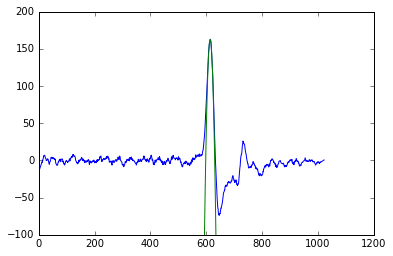

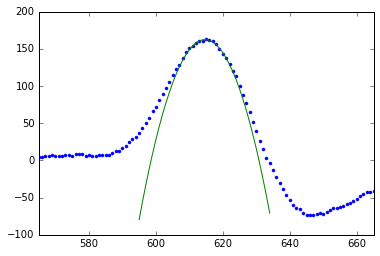

In [15]:
#the filtered_signal is rolling slope over 25 points. instead of convolving with a step function
plot(filtered_signal)
plot(arange(win_c-40,win_c+50),peakFunction(arange(win_c-40,win_c+50),*popt))
ylim(-100,200)
show()
#zooming in
plot(filtered_signal,'.')
window_size = 20
plot(arange(win_c-window_size,win_c+window_size),peakFunction(arange(win_c-window_size,win_c+window_size),*popt))
xlim(win_c-50,win_c+50)
show()


## Histogram of the pixel values for the rising edge

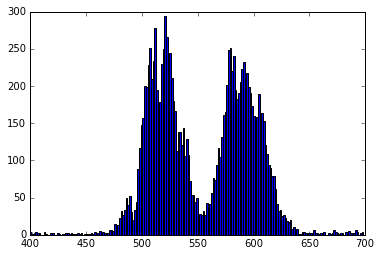

In [16]:
hist(recalculated_atm,bins=arange(400,700,1.5))
show()